# CS 109A/STAT 121A/AC 209A/CSCI E-109A: 
# Final Project - 2017

**Harvard University**<br/>
**Fall 2017**<br/>
**Instructors**: Pavlos Protopapas, Kevin Rader, Rahul Dave, Margo Levine<br/>
**Leading TF**: Albert Wu<br/>
**Project Group #**: 16 (Sports)

---

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import IFrame, HTML
import requests
from bs4 import BeautifulSoup
import seaborn as sns
import sys
import json

In [2]:
def process_game_play(url):

    game_pd = pd.read_html(url, header=1)[0]

    # Set proper initial headers
    away_team = game_pd.columns[1]
    home_team = game_pd.columns[5]
    game_pd.columns = ['time', 'away_events','away_pts','score','home_pts','home_events']
    game_pd['away_team'] = away_team
    game_pd['home_team'] = home_team

    # Combine home and away team events
    events = game_pd['home_events']
    events = events.fillna(game_pd['away_events'])
    game_pd['events'] = events
    game_pd['is_home_event'] = 1 - pd.isnull(game_pd['home_events'])

    # Fill invalid scores
    game_pd['score'] = game_pd['score'].replace(to_replace='Score',method='ffill')
    game_pd['score'] = game_pd['score'].fillna(method='backfill')
    game_pd = game_pd.drop(game_pd.index[game_pd['score'].isnull()], axis=0)

    # Process scores
    score_str = game_pd['score'].str.split('-').tolist()
    away_score,home_score = np.transpose(np.array(score_str))
    away_score = away_score.astype(int)
    home_score = home_score.astype(int)
    away_score[:2] = 0
    home_score[:2] = 0
    game_pd['away_score'] = away_score
    game_pd['home_score'] = home_score
    game_pd['score_diff'] = home_score - away_score
    game_pd['home_win'] = (home_score[-1] > away_score[-1]).astype(int)

    # Drop useless columns
    game_pd = game_pd.drop(['away_events', 'away_pts', 'score', 'home_pts', 'home_events'], axis=1)

    # Calculat elapsed time
    game_pd['t_elapsed'] = game_pd['time'].str.split(':')
    quarter_str = ['2nd Q', '3rd Q', '4th Q', '1st OT', '2nd OT', '3rd OT', '4th OT']
    last_ind = 0
    for i in range(len(quarter_str)):
        if any(game_pd['time'].str.contains(quarter_str[i])):
            ind_Q = game_pd.index[game_pd['time'].str.contains(quarter_str[i])][0]
            game_pd = game_pd.drop(np.arange(ind_Q-1, ind_Q+3, 1).tolist(), axis=0)
            game_pd.loc[last_ind:ind_Q, 't_elapsed'] = game_pd.loc[last_ind:ind_Q, 't_elapsed'].apply(
                lambda s: 720*np.min([4, i+1]) + 300*np.max([0, i-2]) - (float(s[0])*60+float(s[1])))
            last_ind = ind_Q
        else:
            game_pd.loc[last_ind:, 't_elapsed'] = game_pd.loc[last_ind:, 't_elapsed'].apply(
                lambda s: 720*4 + 300*np.max([0, i-3]) - (float(s[0])*60+float(s[1])))
            break
    game_pd = game_pd.drop(0, axis=0).reset_index(drop=True)

    # Process event information
    event_type = ['makes', 'miss', '2-pt', '3-pt', 'free throw', 'assist', 'Defensive rebound', 
                  'Offensive rebound', 'Turnover', 'foul']
    for e in event_type:
        game_pd[e.replace(' ', '_')] = game_pd['events'].str.contains(e).astype(int)

    game_pd['substitution'] = game_pd['events'].str.contains('enters the game for').astype(int)
    game_pd['timeout'] = game_pd['events'].str.contains('full timeout').astype(int)
    
    # Calculate Shooting percetage
    home_perc = (game_pd['is_home_event']*(game_pd['makes']*(1-game_pd['free_throw']))).cumsum()/(game_pd['is_home_event']*(game_pd['makes']+game_pd['miss']-game_pd['free_throw'])).cumsum()
    home_perc = home_perc.fillna(0)
    away_perc = ((1-game_pd['is_home_event'])*(game_pd['makes']*(1-game_pd['free_throw']))).cumsum()/((1-game_pd['is_home_event'])*(game_pd['makes']+game_pd['miss']-game_pd['free_throw'])).cumsum()
    away_perc = away_perc.fillna(0)

    game_pd['home_perc'] = home_perc
    game_pd['away_perc'] = away_perc
    
    return game_pd


In [3]:
# Process all games from 2014-2015, 2015-2016, 2016-2017 season

url_base = 'https://www.basketball-reference.com/leagues/NBA_year_games-month.html'

years = ['2015', '2016', '2017']
months = ['october', 'november', 'december', 'january', 'february', 'march', 
         'april', 'may', 'june']

game_urls = []
count = 0
for y in years[0:1]:
    for m in months[0:3]:
        url_schedule = url_base.replace('year', y)
        url_schedule = url_schedule.replace('month', m)
        response = requests.get(url_schedule)
        soup = BeautifulSoup(response.text, 'lxml')
        for ref in soup.find_all('a'):
            link = ref.get('href')
            if link.startswith('/boxscores/2'):
                game_urls.append('https://www.basketball-reference.com' + link.replace('boxscores/', 'boxscores/pbp/'))
        count += 1
        sys.stdout.write("\rProgress: %.3f%%" % (100*count/(len(years)*len(months))))
        sys.stdout.flush()

Progress: 11.111%

In [4]:
len(game_urls)

481

In [5]:
# Don't rerun this at re-start
# This will take a long time
game_pd_dict = dict()
for ind in range(len(game_urls)):
    game_pd_dict['game_%d' % ind] = process_game_play(game_urls[ind])
    sys.stdout.write("\rProgress: %.3f%%" % (100*(ind+1)/len(game_urls)))
    sys.stdout.flush()

Progress: 100.000%

In [10]:
print(len(game_pd_dict))
game_pd_dict['game_0'].head()

481


,time,away_team,home_team,events,is_home_event,away_score,home_score,score_diff,home_win,t_elapsed,...,3-pt,free_throw,assist,Defensive_rebound,Offensive_rebound,Turnover,foul,substitution,home_perc,away_perc
0,12:00.0,Houston,LA Lakers,Jump ball: J. Hill vs. D. Howard (C. Boozer ga...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.0,0.0
1,11:40.0,Houston,LA Lakers,C. Boozer misses 2-pt shot from 8 ft,1,0,0,0,0,20,...,0,0,0,0,0,0,0,0,0.0,0.0
2,11:39.0,Houston,LA Lakers,Defensive rebound by D. Howard,0,0,0,0,0,21,...,0,0,0,1,0,0,0,0,0.0,0.0
3,11:23.0,Houston,LA Lakers,D. Howard makes 2-pt shot from 5 ft (assist by...,0,2,0,-2,0,37,...,0,0,1,0,0,0,0,0,0.0,1.0
4,11:05.0,Houston,LA Lakers,J. Hill misses 2-pt shot from 1 ft,1,2,0,-2,0,55,...,0,0,0,0,0,0,0,0,0.0,1.0


In [7]:
# Save all the game DataFrames into a xlsx file
writer = pd.ExcelWriter('game_pd_dict.xlsx')
for game in game_pd_dict:
    game_pd_dict[game].to_excel(writer, game)
writer.save()
del game_pd_dict

In [8]:
# Read all Processed DataFrame back
game_pd_dict = pd.read_excel('game_pd_dict.xlsx', sheetname=None)

In [55]:
t_range = np.arange(0, 2880, 1)
l_range = np.arange(-40, 40, 1)

win_count = np.zeros((len(l_range), len(t_range)))
game_count = np.zeros((len(l_range), len(t_range)))

count = 0

for game in game_pd_dict:
    game_pd = game_pd_dict[game]
    t_game = game_pd['t_elapsed'].values
    l_game = game_pd['score_diff'].values - l_range.min()
    home_win = game_pd.loc[0, 'home_win']
    
    win_count_temp = np.zeros((len(l_range), len(t_range)))
    game_count_temp = np.zeros((len(l_range), len(t_range)))

    for ind in range(len(game_pd)):
        win_count_temp[np.max([l_game[ind]-2, 0]):np.min([l_game[ind]+2, len(l_range)-1]), 
                       np.max([t_game[ind]-2, 0]):np.min([t_game[ind]+2, len(t_range)-1])] = home_win
        game_count_temp[np.max([l_game[ind]-2, 0]):np.min([l_game[ind]+2, len(l_range)-1]), 
                        np.max([t_game[ind]-2, 0]):np.min([t_game[ind]+2, len(t_range)-1])] = 1
    
    win_count += win_count_temp
    game_count += game_count_temp
    
    count += 1
    sys.stdout.write("\rProgress: %.3f%%" % (100*count/len(game_pd_dict)))
    sys.stdout.flush()

Progress: 100.000%

In [57]:
win_count[0:21, :][win_count[0:21, :] > 0] += 1
win_count[21:61, :][win_count[21:61, :] > 0] += 2
win_count[61:80, :][win_count[61:80, :] > 0] += 3
game_count[game_count > 0] += 4

In [58]:
win_perc = np.flip(win_count/game_count, 0)

D:\Anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


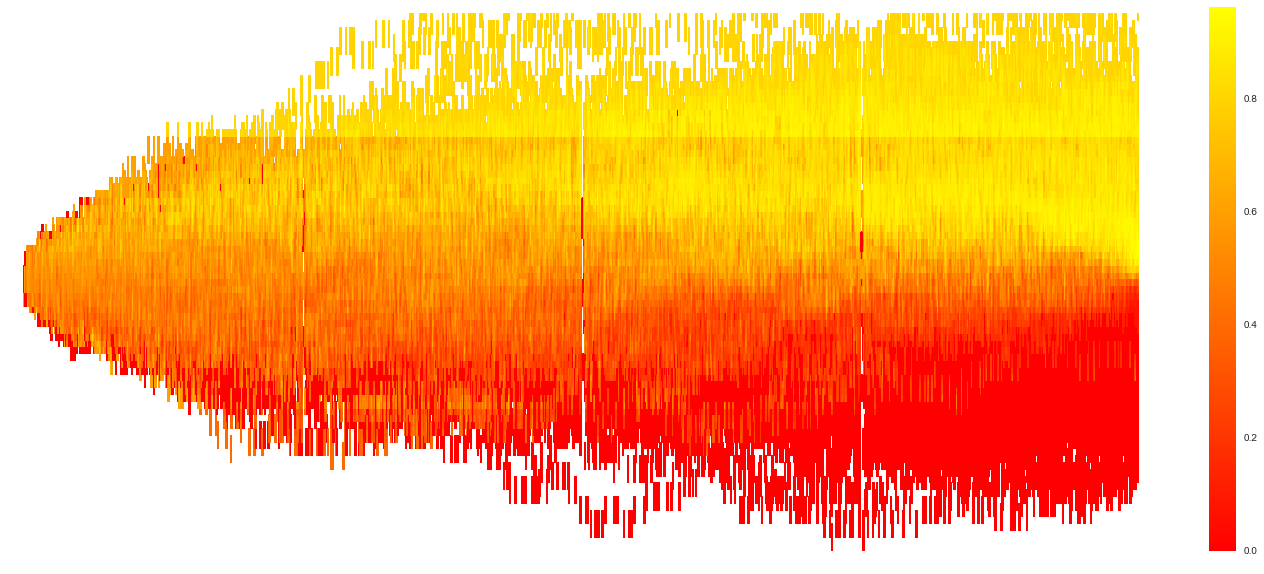

In [59]:
plt.figure(figsize=(25, 10))
plt.axis('off')
sns.heatmap(win_perc, cmap='autumn')
plt.show()